In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prerequisites: Load data

In [3]:
# set up constants

BASE_GENRES = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock"
]

STRATIFY = ['stratify']

KEY = ['metadata_path']

In [4]:
# load base dataframe

import pandas as pd

filepath = "/content/drive/MyDrive/w207/mids_w207_music_genre/member_workspaces/lawrence/mtg_jamendo_genre_features_base.feather"
df_base = pd.read_feather(filepath)

In [5]:
# split base data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np


# get features
FEATURES = list(set(df_base.columns) - set(BASE_GENRES) - set(STRATIFY) - set(KEY))
X = df_base[FEATURES]

# get targets
enc = LabelEncoder()
y = enc.fit_transform(df_base[STRATIFY].values.reshape(-1))

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
  
# X_train, X_valid, y_train, y_valid = \
#     train_test_split(X_train, y_train, test_size=0.25, random_state=10, stratify=y_train)

print(F"X_train: {X_train.shape}")
# print(F"X_valid: {X_valid.shape}")
print(F"X_test:  {X_test.shape}")

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
# X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


X_train: (17080, 2739)
X_test:  (4271, 2739)


---

# XGBoost w/o feature selection

## Experiment \#1: XGBoost with default parameters

In [6]:
# compute sample weight
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

clf = XGBClassifier(n_jobs=-1, tree_method='gpu_hist')
clf.fit(X_train, y_train, verbose=1, sample_weight=sample_weight)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
test_accuracy = accuracy_score(y_test, clf.predict(X_test))

print(F"Train accuracy: {train_accuracy}")
print(F"Test accuracy:  {test_accuracy}")

Train accuracy: 0.7795667447306791
Test accuracy:  0.7012409271833294


## Experiment \#2: XGBoost with different n_estimators

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

tolerance = 10
n_estimators_list = np.arange(10, 110, 10)
train_accuracies = []
test_accuracies = []

for n_estimators in n_estimators_list:
  clf = XGBClassifier(n_jobs=-1, tree_method='gpu_hist', n_estimators=n_estimators)
  clf.fit(X_train, y_train, verbose=1, sample_weight=sample_weight)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test))
  test_accuracies.append(test_accuracy)

  print(F"Training XGBoost with n_estimators={n_estimators}...")
  print(clf)
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Training XGBoost with n_estimators=10...
Train accuracy: 0.6135245901639345
Test accuracy:  0.6000936548817607
----------------------------------------------------------------------------------------------------
Training XGBoost with n_estimators=20...
Train accuracy: 0.6450819672131147
Test accuracy:  0.6216342776867244
----------------------------------------------------------------------------------------------------
Training XGBoost with n_estimators=30...
Train accuracy: 0.672248243559719
Test accuracy:  0.6394287052212596
----------------------------------------------------------------------------------------------------
Training XGBoost with n_estimators=40...
Train accuracy: 0.6911007025761124
Test accuracy:  0.6525403886677593
----------------------------------------------------------------------------------------------------
Training XGBoost with n_estimators=50...
Train accuracy: 0.7108313817330211
Test accuracy:  0.6672910325450714
------------------------------------------

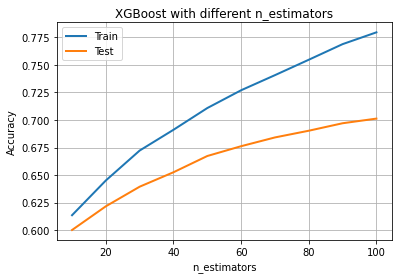

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_estimators_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_estimators_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("XGBoost with different n_estimators")
ax.set_xlabel("n_estimators")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#3: XGBoost with different max_depth

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

tolerance = 10
max_depths = np.arange(1, 101, 1)
train_accuracies = []
test_accuracies = []

for max_depth in max_depths:
  clf = XGBClassifier(n_jobs=-1, tree_method='gpu_hist', max_depth=max_depth)
  clf.fit(X_train, y_train, verbose=1, sample_weight=sample_weight)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test))
  test_accuracies.append(test_accuracy)

  print(F"Training XGBoost with max_depth={max_depth}...")
  print(clf)
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Training XGBoost with max_depth=1...
Train accuracy: 0.6042154566744731
Test accuracy:  0.5991571060641536
----------------------------------------------------------------------------------------------------
Training XGBoost with max_depth=2...
Train accuracy: 0.6944964871194379
Test accuracy:  0.6605010536174198
----------------------------------------------------------------------------------------------------
Training XGBoost with max_depth=3...
Train accuracy: 0.7795667447306791
Test accuracy:  0.7012409271833294
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training XGBoost with max_depth=4...
Train accuracy: 0.8543911007025761
Test accuracy:  0.735659096230391
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training XGBoost with max_depth=5...
Train accuracy: 0.9187353629976581
Test accuracy:  0.7583704050573636
Overfitting detect

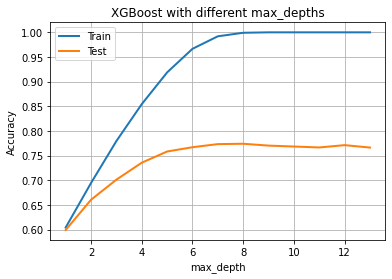

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(max_depths[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(max_depths[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("XGBoost with different max_depths")
ax.set_xlabel("max_depth")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#4: XGBoost with different learning_rate

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

tolerance = 10
learning_rates = np.arange(1, 11, 1)/10
train_accuracies = []
test_accuracies = []

for learning_rate in learning_rates:
  clf = XGBClassifier(n_jobs=-1, tree_method='gpu_hist', learning_rate=learning_rate)
  clf.fit(X_train, y_train, verbose=1, sample_weight=sample_weight)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test))
  test_accuracies.append(test_accuracy)

  print(F"Training XGBoost with learning_rate={learning_rate}...")
  print(clf)
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy == 1:
    break

  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Training XGBoost with learning_rate=0.1...
XGBClassifier(n_jobs=-1, objective='multi:softprob', tree_method='gpu_hist')
Train accuracy: 0.7795667447306791
Test accuracy:  0.7012409271833294
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training XGBoost with learning_rate=0.2...
XGBClassifier(learning_rate=0.2, n_jobs=-1, objective='multi:softprob',
              tree_method='gpu_hist')
Train accuracy: 0.8535128805620609
Test accuracy:  0.7380004682744088
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training XGBoost with learning_rate=0.3...
XGBClassifier(learning_rate=0.3, n_jobs=-1, objective='multi:softprob',
              tree_method='gpu_hist')
Train accuracy: 0.9002927400468385
Test accuracy:  0.7520487005385156
Overfitting detected!
------------------------------------------------------------------------------------------------

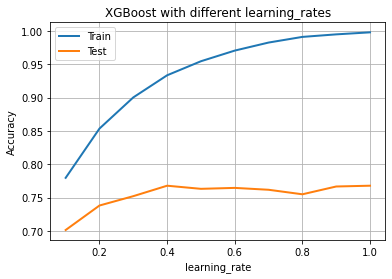

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(learning_rates[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(learning_rates[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("XGBoost with different learning_rates")
ax.set_xlabel("learning_rate")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#5: XGBoost with different colsample_bytree

In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

tolerance = 10
colsample_bytree_list = np.arange(1, 11, 1)/10
train_accuracies = []
test_accuracies = []

for colsample_bytree in colsample_bytree_list:
  clf = XGBClassifier(n_jobs=-1, tree_method='gpu_hist', colsample_bytree=colsample_bytree)
  clf.fit(X_train, y_train, verbose=1, sample_weight=sample_weight)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test))
  test_accuracies.append(test_accuracy)

  print(F"Training XGBoost with colsample_bytree={colsample_bytree}...")
  print(clf)
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy == 1:
    break
    
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Training XGBoost with colsample_bytree=0.1...
XGBClassifier(colsample_bytree=0.1, n_jobs=-1, objective='multi:softprob',
              tree_method='gpu_hist')
Train accuracy: 0.7597189695550352
Test accuracy:  0.6808709904003746
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training XGBoost with colsample_bytree=0.2...
XGBClassifier(colsample_bytree=0.2, n_jobs=-1, objective='multi:softprob',
              tree_method='gpu_hist')
Train accuracy: 0.7703161592505855
Test accuracy:  0.6991336923437134
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training XGBoost with colsample_bytree=0.3...
XGBClassifier(colsample_bytree=0.3, n_jobs=-1, objective='multi:softprob',
              tree_method='gpu_hist')
Train accuracy: 0.7753512880562061
Test accuracy:  0.7054553968625614
Overfitting detected!
---------------------------------------------

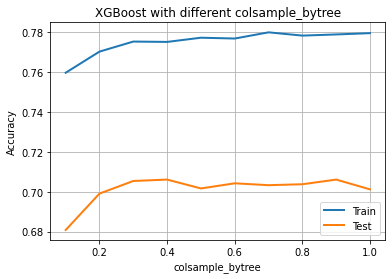

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(colsample_bytree_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(colsample_bytree_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("XGBoost with different colsample_bytree")
ax.set_xlabel("colsample_bytree")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#6: XGBoost with different subsample

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

tolerance = 10
subsamples = np.arange(1, 11, 1)/10
train_accuracies = []
test_accuracies = []

for subsample in subsamples:
  clf = XGBClassifier(n_jobs=-1, tree_method='gpu_hist', subsample=subsample)
  clf.fit(X_train, y_train, verbose=1, sample_weight=sample_weight)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test))
  test_accuracies.append(test_accuracy)

  print(F"Training XGBoost with subsample={subsample}...")
  print(clf)
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy == 1:
    break
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Training XGBoost with subsample=0.1...
XGBClassifier(n_jobs=-1, objective='multi:softprob', subsample=0.1,
              tree_method='gpu_hist')
Train accuracy: 0.7591920374707259
Test accuracy:  0.6942168110512761
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training XGBoost with subsample=0.2...
XGBClassifier(n_jobs=-1, objective='multi:softprob', subsample=0.2,
              tree_method='gpu_hist')
Train accuracy: 0.7669203747072599
Test accuracy:  0.7005385155701241
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training XGBoost with subsample=0.3...
XGBClassifier(n_jobs=-1, objective='multi:softprob', subsample=0.3,
              tree_method='gpu_hist')
Train accuracy: 0.7752927400468385
Test accuracy:  0.6979630063217045
Overfitting detected!
---------------------------------------------------------------------------------------

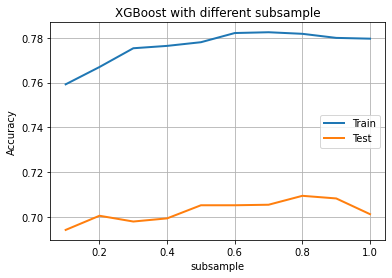

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(subsamples[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(subsamples[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("XGBoost with different subsample")
ax.set_xlabel("subsample")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()